# Nettoyage

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import pickle

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

In [2]:
df=pd.read_csv('dpe_Bret.csv')

region="Bretagne"

C:\Users\lilym\AppData\Local\Temp\ipykernel_25488\107228809.py:1: DtypeWarning: Columns (47,75,156,182,183,209,213) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('dpe_Bret.csv')


In [3]:
df

,configuration_installation_chauffage_n1,conso_chauffage_installation_chauffage_n1,type_generateur_n1_ecs_n1,numero_voie_ban,score_ban,conso_auxiliaires_ep,deperditions_murs,cout_eclairage,conso_auxiliaires_ef,statut_geocodage,ventilation_posterieure_2012,cout_chauffage,conso_5_usages_par_m2_ep,date_etablissement_dpe,conso_ecs_ef_energie_n1,emission_ges_chauffage,description_installation_chauffage_n1,qualite_isolation_plancher_haut_comble_amenage,conso_5_usages_par_m2_ef,conso_chauffage_ef_energie_n1,presence_brasseur_air,qualite_isolation_menuiseries,date_reception_dpe,cout_total_5_usages_energie_n1,cout_ecs_energie_n1,qualite_isolation_plancher_bas,isolation_toiture,modele_dpe,qualite_isolation_enveloppe,conso_chauffage_generateur_n1_installation_n1,type_energie_n1,emission_ges_eclairage,code_postal_ban,emission_ges_ecs,conso_5_usages_ef,conso_5_usages_ef_energie_n1,code_insee_ban,deperditions_planchers_bas,conso_5_usages_ep,date_fin_validite_dpe,deperditions_enveloppe,code_region_ban,volume_stockage_generateur_n1_ecs_n1,surface_chauffee_installation_chauffage_n1,version_dpe,besoin_ecs,coordonnee_cartographique_x_ban,type_generateur_chauffage_principal,type_energie_principale_ecs,apport_solaire_saison_chauffe,adresse_ban,deperditions_renouvellement_air,_rand,surface_habitable_desservie_par_installation_ecs_n1,production_electricite_pv_kwhep_par_an,nombre_niveau_logement,surface_habitable_logement,cout_ecs,type_installation_ecs_n1,emission_ges_5_usages_energie_n1,apport_interne_saison_froide,emission_ges_5_usages_par_m2,description_generateur_chauffage_n1_installation_n1,qualite_isolation_plancher_haut_comble_perdu,apport_interne_saison_chauffe,apport_solaire_saison_froide,type_generateur_n1_installation_n1,nombre_logements_desservis_par_installation_ecs_n1,cout_auxiliaires,type_emetteur_installation_chauffage_n1,besoin_chauffage,configuration_installation_ecs_n1,description_installation_ecs_n1,classe_inertie_batiment,deperditions_ponts_thermiques,type_generateur_chauffage_principal_ecs,emission_ges_refroidissement,hauteur_sous_plafond,conso_chauffage_ef,nom_commune_ban,annee_construction,_geopoint,date_visite_diagnostiqueur,type_batiment,periode_construction,conso_ecs_ep,protection_solaire_exterieure,conso_ecs_ef,emission_ges_5_usages,date_derniere_modification_dpe,etiquette_ges,identifiant_ban,deperditions_baies_vitrees,type_energie_generateur_n1_ecs_n1,ubat_w_par_m2_k,nom_commune_brut,conso_ef_installation_ecs_n1,etiquette_dpe,description_generateur_n1_ecs_n1,code_departement_ban,type_installation_chauffage_n1,methode_application_dpe,adresse_brut,logement_traversant,cout_total_5_usages,conso_refroidissement_ef,conso_eclairage_ef,deperditions_planchers_hauts,zone_climatique,conso_ef_generateur_n1_ecs_n1,emission_ges_ecs_energie_n1,cout_refroidissement,conso_chauffage_ep,conso_eclairage_ep,usage_generateur_n1_installation_n1,nom_rue_ban,qualite_isolation_murs,type_installation_solaire_n1,classe_altitude,adresse_complete_brut,conso_refroidissement_ep,type_energie_principale_chauffage,numero_dpe,_i,besoin_refroidissement,indicateur_confort_ete,emission_ges_chauffage_energie_n1,inertie_lourde,deperditions_portes,cout_chauffage_energie_n1,coordonnee_cartographique_y_ban,type_energie_generateur_n1_installation_n1,code_postal_brut,emission_ges_auxiliaires,usage_generateur_n1_ecs_n1,_score,_id,provenance_id_rnb,complement_adresse_batiment,id_rnb,numero_etage_appartement,categorie_enr,surface_habitable_immeuble,conso_ecs_ef_energie_n2,cout_ecs_energie_n2,conso_chauffage_ef_energie_n2,cout_total_5_usages_energie_n2,type_energie_n2,conso_5_usages_ef_energie_n2,nombre_niveau_immeuble,nombre_appartement,type_installation_chauffage,appartement_non_visite,emission_ges_5_usages_energie_n2,complement_adresse_logement,type_installation_ecs,numero_dpe_immeuble_associe,qualite_isolation_plancher_haut_toit_terrasse,emission_ges_ecs_energie_n2,emission_ges_chauffage_energie_n2,cout_chauffage_energie_n2,configuration_installation_chauffage_n2,con

In [4]:
def profile_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyse un DataFrame pour déterminer le type de données de chaque colonne,
    le nombre de valeurs manquantes (NaN) et le nombre de valeurs uniques.

    Args:
        df: Le DataFrame pandas à analyser.

    Returns:
        Un nouveau DataFrame contenant le profil de chaque colonne.
    """
    
    # Création d'un DataFrame vide pour stocker les résultats de l'analyse
    profile = pd.DataFrame(index=df.columns)
    
    # 1. Type des Variables (dtype)
    profile['Type de Variable'] = df.dtypes
    
    # 2. Nombre de Valeurs Manquantes (NaN)
    profile['Valeurs Manquantes (Count)'] = df.isnull().sum()
    
    # 3. Pourcentage de Valeurs Manquantes
    profile['Valeurs Manquantes (%)'] = (df.isnull().sum() / len(df)) * 100
    
    # 4. Nombre de Catégories Uniques (Cardinalité)
    profile['Nombre de Catégories Uniques'] = df.nunique()
    
    # 5. Type de Données Inférencé (Numérique, Catégorique, Date/Heure)
    def determine_data_class(series, max_unique_ratio=0.1):
        n_unique = series.nunique()
        n_rows = len(series)
        dtype = series.dtype

        # Si le type est déjà datetime
        if pd.api.types.is_datetime64_any_dtype(dtype):
            return 'Date/Heure'
        
        # Si c'est un type numérique
        if pd.api.types.is_numeric_dtype(dtype):
            # Si le nombre de valeurs uniques est inférieur à 10% de la taille, c'est probablement catégorique
            if n_unique / n_rows < max_unique_ratio and n_unique < 50:
                 return 'Numérique/Catégorique'
            return 'Numérique'
        
        # Pour les types objet (string)
        if dtype == 'object' or dtype == 'category':
            # Si peu de valeurs uniques par rapport au total, c'est catégorique
            if n_unique / n_rows < max_unique_ratio:
                return 'Catégorique'
            return 'Texte (ID/Nom)'
        
        return str(dtype) # Type par défaut

    profile['Classe Inférencée'] = df.apply(determine_data_class)
    
    return profile.sort_values(by='Nombre de Catégories Uniques', ascending=False)



In [5]:
# 2. Lancement de la fonction d'analyse
df_profil = profile_dataframe(df)

# 3. Affichage du résultat
print("="*60)
print("Analyse de Profil du DataFrame :")
print("="*60)
print(df_profil)
print("\n")

Analyse de Profil du DataFrame :
                                                   Type de Variable  \
_i                                                            int64   
_id                                                          object   
numero_dpe                                                   object   
_rand                                                         int64   
adresse_complete_brut                                        object   
...                                                             ...   
usage_generateur_n1_installation_n2                          object   
code_region_ban                                               int64   
modele_dpe                                                   object   
facteur_couverture_solaire_installation_chauffa...          float64   
_score                                                      float64   

                                                    Valeurs Manquantes (Count)  \
_i                              

C:\Users\lilym\AppData\Local\Temp\ipykernel_25488\1884368819.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


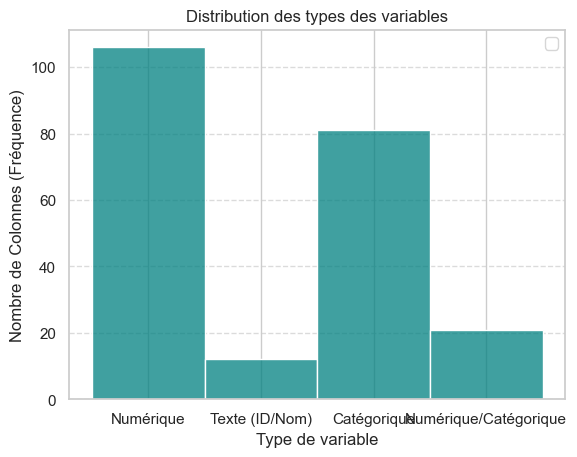

In [6]:
sns.histplot(df_profil['Classe Inférencée'], bins=20, color='teal')

plt.title('Distribution des types des variables')
plt.xlabel('Type de variable')
plt.ylabel('Nombre de Colonnes (Fréquence)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

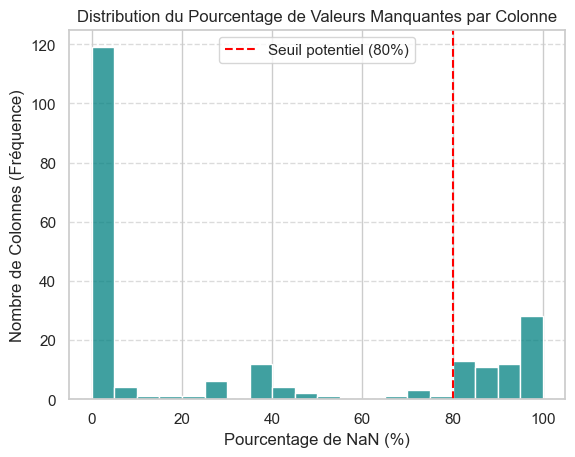

In [7]:
sns.histplot(df_profil['Valeurs Manquantes (%)'], bins=20,  color='teal')
SEUIL_VISUEL = 80
plt.axvline(SEUIL_VISUEL, color='red', linestyle='--', label=f'Seuil potentiel ({SEUIL_VISUEL}%)')

plt.title('Distribution du Pourcentage de Valeurs Manquantes par Colonne')
plt.xlabel('Pourcentage de NaN (%)')
plt.ylabel('Nombre de Colonnes (Fréquence)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [8]:
#Retirer les colonnes où il manque le plus de valeurs

lst=df_profil[df_profil['Valeurs Manquantes (%)']>78].index.values.tolist()
print(len(lst))

df_clean1=df.copy().drop(columns=lst)

df_clean1

64


,configuration_installation_chauffage_n1,conso_chauffage_installation_chauffage_n1,type_generateur_n1_ecs_n1,numero_voie_ban,score_ban,conso_auxiliaires_ep,deperditions_murs,cout_eclairage,conso_auxiliaires_ef,statut_geocodage,ventilation_posterieure_2012,cout_chauffage,conso_5_usages_par_m2_ep,date_etablissement_dpe,conso_ecs_ef_energie_n1,emission_ges_chauffage,description_installation_chauffage_n1,qualite_isolation_plancher_haut_comble_amenage,conso_5_usages_par_m2_ef,conso_chauffage_ef_energie_n1,presence_brasseur_air,qualite_isolation_menuiseries,date_reception_dpe,cout_total_5_usages_energie_n1,cout_ecs_energie_n1,qualite_isolation_plancher_bas,isolation_toiture,modele_dpe,qualite_isolation_enveloppe,conso_chauffage_generateur_n1_installation_n1,type_energie_n1,emission_ges_eclairage,code_postal_ban,emission_ges_ecs,conso_5_usages_ef,conso_5_usages_ef_energie_n1,code_insee_ban,deperditions_planchers_bas,conso_5_usages_ep,date_fin_validite_dpe,deperditions_enveloppe,code_region_ban,volume_stockage_generateur_n1_ecs_n1,surface_chauffee_installation_chauffage_n1,version_dpe,besoin_ecs,coordonnee_cartographique_x_ban,type_energie_principale_ecs,apport_solaire_saison_chauffe,adresse_ban,deperditions_renouvellement_air,_rand,surface_habitable_desservie_par_installation_ecs_n1,production_electricite_pv_kwhep_par_an,nombre_niveau_logement,surface_habitable_logement,cout_ecs,type_installation_ecs_n1,emission_ges_5_usages_energie_n1,apport_interne_saison_froide,emission_ges_5_usages_par_m2,description_generateur_chauffage_n1_installation_n1,qualite_isolation_plancher_haut_comble_perdu,apport_interne_saison_chauffe,apport_solaire_saison_froide,type_generateur_n1_installation_n1,nombre_logements_desservis_par_installation_ecs_n1,cout_auxiliaires,type_emetteur_installation_chauffage_n1,besoin_chauffage,configuration_installation_ecs_n1,description_installation_ecs_n1,classe_inertie_batiment,deperditions_ponts_thermiques,emission_ges_refroidissement,hauteur_sous_plafond,conso_chauffage_ef,nom_commune_ban,annee_construction,_geopoint,date_visite_diagnostiqueur,type_batiment,periode_construction,conso_ecs_ep,protection_solaire_exterieure,conso_ecs_ef,emission_ges_5_usages,date_derniere_modification_dpe,etiquette_ges,identifiant_ban,deperditions_baies_vitrees,type_energie_generateur_n1_ecs_n1,ubat_w_par_m2_k,nom_commune_brut,conso_ef_installation_ecs_n1,etiquette_dpe,description_generateur_n1_ecs_n1,code_departement_ban,type_installation_chauffage_n1,methode_application_dpe,adresse_brut,logement_traversant,cout_total_5_usages,conso_refroidissement_ef,conso_eclairage_ef,deperditions_planchers_hauts,zone_climatique,conso_ef_generateur_n1_ecs_n1,emission_ges_ecs_energie_n1,cout_refroidissement,conso_chauffage_ep,conso_eclairage_ep,usage_generateur_n1_installation_n1,nom_rue_ban,qualite_isolation_murs,type_installation_solaire_n1,classe_altitude,adresse_complete_brut,conso_refroidissement_ep,type_energie_principale_chauffage,numero_dpe,_i,besoin_refroidissement,indicateur_confort_ete,emission_ges_chauffage_energie_n1,inertie_lourde,deperditions_portes,cout_chauffage_energie_n1,coordonnee_cartographique_y_ban,type_energie_generateur_n1_installation_n1,code_postal_brut,emission_ges_auxiliaires,usage_generateur_n1_ecs_n1,_id,provenance_id_rnb,complement_adresse_batiment,id_rnb,numero_etage_appartement,categorie_enr,surface_habitable_immeuble,conso_ecs_ef_energie_n2,cout_ecs_energie_n2,conso_chauffage_ef_energie_n2,cout_total_5_usages_energie_n2,type_energie_n2,conso_5_usages_ef_energie_n2,nombre_niveau_immeuble,nombre_appartement,type_installation_chauffage,appartement_non_visite,emission_ges_5_usages_energie_n2,complement_adresse_logement,type_installation_ecs,emission_ges_ecs_energie_n2,emission_ges_chauffage_energie_n2,cout_chauffage_energie_n2
0,Installation de chauffage simple,13955.1,Ballon électrique à accumulation vertical Autr...,8,0.86,0.0,158.0,17.0,0.0,adresse géocodée ban à l'adresse,0,2282.0,517.0,2022-04-02,1269.0,1102.5,Installa

In [9]:
#Supprimer les noms de colonnes à plus de 80% de valeurs manquantes dans df_profil

df_profil=df_profil.drop(lst)

df_profil


,Type de Variable,Valeurs Manquantes (Count),Valeurs Manquantes (%),Nombre de Catégories Uniques,Classe Inférencée
_i,int64,0,0.000000,599000,Numérique
_id,object,0,0.000000,599000,Texte (ID/Nom)
numero_dpe,object,0,0.000000,599000,Texte (ID/Nom)
_rand,int64,0,0.000000,450600,Numérique
adresse_complete_brut,object,0,0.000000,401470,Texte (ID/Nom)
...,...,...,...,...,...
logement_traversant,float64,164161,27.405843,2,Numérique/Catégorique
inertie_lourde,float64,171033,28.553088,2,Numérique/Catégorique
provenance_id_rnb,object,256338,42.794324,2,Catégorique
code_region_ban,int64,0,0.000000,1,Numérique/Catégorique


C:\Users\lilym\AppData\Local\Temp\ipykernel_25488\2022057862.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


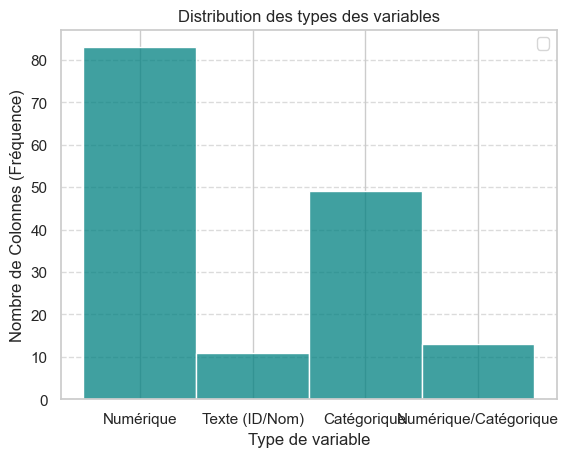

In [10]:
sns.histplot(df_profil['Classe Inférencée'], bins=30, color='teal')

plt.title('Distribution des types des variables')
plt.xlabel('Type de variable')
plt.ylabel('Nombre de Colonnes (Fréquence)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [11]:
def analyze_nan_by_row(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calcule le nombre et le pourcentage de NaN pour chaque ligne d'un DataFrame.

    Args:
        df: Le DataFrame pandas à analyser.

    Returns:
        Le DataFrame original avec deux nouvelles colonnes d'analyse.
    """
    

    # 1. Calcul du nombre de NaN par ligne
    df['nan_count_ligne'] = df.isnull().sum(axis=1)

    # 2. Calcul du pourcentage de NaN par ligne
    df['nan_pourcentage_ligne'] = (df['nan_count_ligne'] / (len(df.columns) - 1)) * 100

    return df

In [12]:
df_clean2=analyze_nan_by_row(df_clean1.copy())

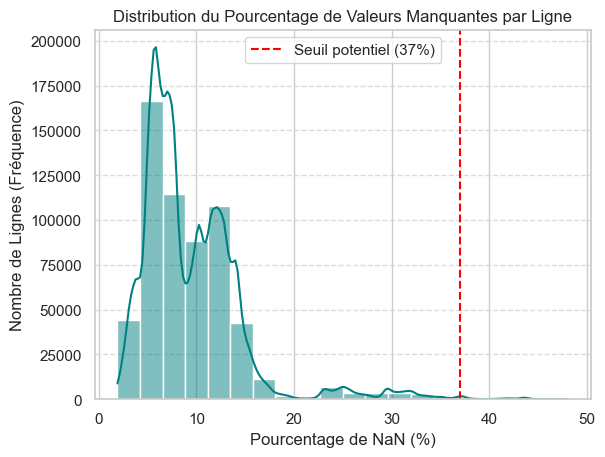

In [13]:
sns.histplot(df_clean2['nan_pourcentage_ligne'], bins=20, kde=True, color='teal')
SEUIL_VISUEL = 37
plt.axvline(SEUIL_VISUEL, color='red', linestyle='--', label=f'Seuil potentiel ({SEUIL_VISUEL}%)')

plt.title('Distribution du Pourcentage de Valeurs Manquantes par Ligne')
plt.xlabel('Pourcentage de NaN (%)')
plt.ylabel('Nombre de Lignes (Fréquence)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [14]:
def drop_rows_by_na_threshold(df: pd.DataFrame, threshold_percent) -> pd.DataFrame:
    """
    Supprime les lignes d'un DataFrame dont le pourcentage de valeurs 
    manquantes (NaN) est supérieur ou égal au seuil spécifié.

    Args:
        df: Le DataFrame pandas à nettoyer.
        threshold_percent: Le seuil de NaN à ne pas dépasser (en pourcentage, ex: 30 pour 30%).

    Returns:
        Un nouveau DataFrame nettoyé.
    """
    
    # 1. Calculer le nombre minimal de valeurs NON-MANQUANTES (valides)
    # Le seuil est appliqué au nombre de valeurs présentes, pas au nombre de NaN.
    
    # Calculer le ratio de valeurs NON-manquantes
    valid_ratio = 1 - (threshold_percent / 100)
    
    # Calculer le nombre minimum de valeurs non-NaN requises par ligne
    min_valid_count = int(np.floor(len(df.columns) * valid_ratio))
    
    # Si le seuil est 0, on garde tout le monde (sauf si on enlève les lignes vides)
    if threshold_percent == 100:
        min_valid_count = 1 # Garde toute ligne qui a au moins 1 valeur non-NaN

    print(f"Nombre total de colonnes : {len(df.columns)}")
    print(f"Seuil de NaN max autorisé : {threshold_percent}%")
    print(f"Nombre MINIMAL de valeurs valides requises par ligne : {min_valid_count}")
    
    # 2. Appliquer la suppression avec .dropna(thresh=...)
    # On crée une copie pour ne pas modifier le DataFrame original passé en argument
    df_cleaned = df.copy().dropna(axis=0, thresh=min_valid_count)
    
    lignes_supprimees = len(df) - len(df_cleaned)
    print(f"Lignes supprimées : {lignes_supprimees} (soit {lignes_supprimees/len(df)*100:.2f}%)")
    
    return df_cleaned

In [15]:
df_clean3 = drop_rows_by_na_threshold(df_clean2,37)

Nombre total de colonnes : 158
Seuil de NaN max autorisé : 37%
Nombre MINIMAL de valeurs valides requises par ligne : 99
Lignes supprimées : 823 (soit 0.14%)


In [16]:
def drop_nan_columns(df, threshold, use_percentage=True):
    """
    Supprime les colonnes ayant trop de valeurs manquantes (NaN).
    
    Args:
        df (pd.DataFrame): Ton DataFrame.
        threshold (float): Le seuil de tolérance. 
        use_percentage (bool): Si True, le seuil est un ratio (ex: 0.5 pour 50%).
                               Si False, le seuil est le nombre maximum de NaN autorisés.
    
    Returns:
        pd.DataFrame: Le DataFrame nettoyé.
    """
    if use_percentage:
        # On calcule le ratio de NaN par colonne
        nan_ratio = df.isna().mean()
        cols_to_drop = nan_ratio[nan_ratio > threshold].index
    else:
        # On compte le nombre brut de NaN
        nan_count = df.isna().sum()
        cols_to_drop = nan_count[nan_count > threshold].index
    
    print(f"Colonnes supprimées : {list(cols_to_drop)}")
    return df.drop(columns=cols_to_drop)

In [17]:
df_clean_final = drop_nan_columns(df_clean3.copy(),70)

Colonnes supprimées : []


## 2. Préparation et Nettoyage des Données

Pour prédire la **consommation électrique théorique (Énergie Primaire)**, nous allons :
1.  **Filtrer** les logements dont l'énergie principale de chauffage est l'électricité.
2.  **Créer des variables simplifiées** compréhensibles par l'utilisateur (ex: Type de chauffage simplifié).
3.  **Sélectionner** les variables explicatives (features) pertinentes.
4.  **Nettoyer** les valeurs manquantes et aberrantes.

C:\Users\lilym\AppData\Local\Temp\ipykernel_25488\4001443047.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=repartition.index, y=repartition.values, palette="viridis")


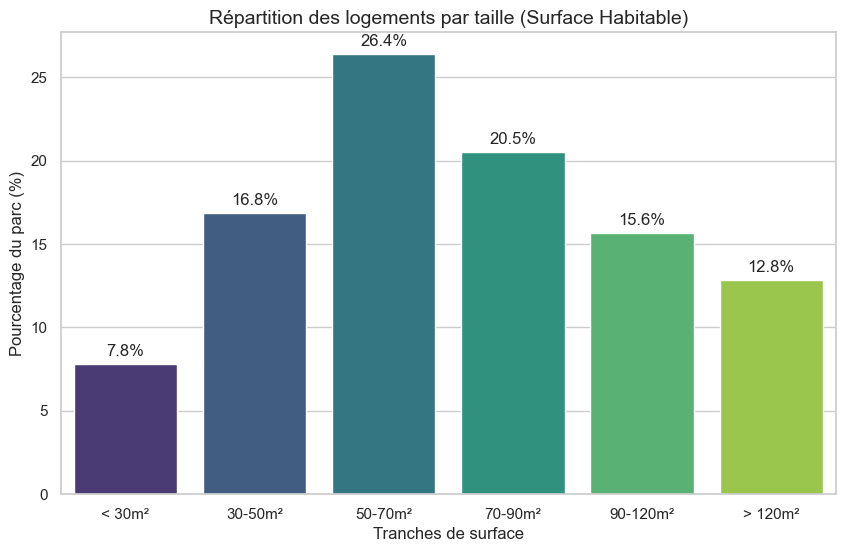

In [18]:
# 1. Définition des tranches de surface (bins)
bins = [0, 30, 50, 70, 90, 120, float('inf')]
labels = ['< 30m²', '30-50m²', '50-70m²', '70-90m²', '90-120m²', '> 120m²']

# 2. Création de la nouvelle colonne de segmentation
# On vérifie si la colonne existe avant de traiter
surface_col = 'surface_habitable_logement'

if surface_col in df_clean_final.columns:
    # On retire les valeurs aberrantes ou nulles pour le graphique
    df_clean = df_clean_final[df_clean_final[surface_col] > 0].copy()
    
    df_clean['tranche_surface'] = pd.cut(df_clean[surface_col], bins=bins, labels=labels)

    # 3. Calcul de la répartition
    repartition = df_clean['tranche_surface'].value_counts(normalize=True).sort_index() * 100

    # 4. Visualisation
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    ax = sns.barplot(x=repartition.index, y=repartition.values, palette="viridis")

    plt.title('Répartition des logements par taille (Surface Habitable)', fontsize=14)
    plt.xlabel('Tranches de surface', fontsize=12)
    plt.ylabel('Pourcentage du parc (%)', fontsize=12)

    # Ajout des étiquettes de pourcentage sur les barres
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points')

    plt.show()
else:
    print(f"La colonne {surface_col} est introuvable. Vérifie le nom exact dans ton dataset.")

In [19]:
# 1. Simplification du type de chauffage
def simplifier_chauffage(val):
    if pd.isna(val):
        return 'Autre/Inconnu'
    val = str(val).lower()
    if 'pac' in val or 'pompe' in val or 'thermodynamique' in val:
        return 'Pompe à Chaleur (PAC)'
    elif 'radiateur' in val or 'convecteur' in val or 'panneau' in val or 'rayonnant' in val or 'standard' in val:
        return 'Radiateur Électrique (Effet Joule)'
    elif 'chaudière' in val:
        return 'Chaudière Électrique'
    else:
        return 'Autre Élec'


if not df_clean_final.empty:
    # Filtrage pour l'électricité
    # Note: On vérifie si la colonne existe, car le nom peut varier légèrement selon les versions du CSV
    if 'type_energie_principale_chauffage' in df.columns:
        df_elec = df_clean_final[df_clean_final['type_energie_principale_chauffage'] == 'Électricité'].copy()
    else:
        print("Attention : Colonne 'type_energie_principale_chauffage' introuvable. Utilisation du dataset complet (risqué).")
        df_elec = df_clean_final.copy()
        
    print(f"Nombre de logements sélectionnés (Chauffage Élec) : {df_elec.shape[0]}")

    # --- Création de features simplifiées ---


    if 'type_generateur_chauffage_principal' in df_elec.columns:
        df_elec['chauffage_simplifie'] = df_elec['type_generateur_chauffage_principal'].apply(simplifier_chauffage)
    else:
        df_elec['chauffage_simplifie'] = 'Inconnu'

    # 2. Logement Traversant
    if 'logement_traversant' in df_elec.columns:
        df_elec['logement_traversant_clean'] = df_elec['logement_traversant'].map({1.0: 'Oui', 0.0: 'Non'}).fillna('Inconnu')
    else:
         df_elec['logement_traversant_clean'] = 'Inconnu'

    # 3. Isolation Toiture
    if 'isolation_toiture' in df_elec.columns:
        df_elec['isolation_toiture_clean'] = df_elec['isolation_toiture'].map({1.0: 'Isolé', 0.0: 'Non Isolé'}).fillna('Inconnu')
    else:
        df_elec['isolation_toiture_clean'] = 'Inconnu'

    bins = [0, 30, 50, 70, 90, 120, float('inf')]
    labels = ['< 30m²', '30-50m²', '50-70m²', '70-90m²', '90-120m²', '> 120m²']

    df_elec['tranche_surface'] = pd.cut(
        df_elec['surface_habitable_logement'], 
        bins=bins, 
        labels=labels, 
        include_lowest=True
    )

    # Sélection des features (X) et de la target (y)
    target_col = 'conso_5_usages_ep' # Updated to Primary Energy

    # Liste enrichie de variables "connues de l'utilisateur"
    features_num = [
        'surface_habitable_logement',
        'annee_construction', 
        'hauteur_sous_plafond'
    ]

    features_cat = [
        'type_batiment', 
        'zone_climatique', 
        'classe_altitude',
        'chauffage_simplifie',        
        'logement_traversant_clean',  
        'isolation_toiture_clean'     
    ]
    
    # Filtrer uniquement les colonnes présentes
    features_num = [c for c in features_num if c in df_elec.columns]
    features_cat = [c for c in features_cat if c in df_elec.columns]

    print("Variables numériques utilisées :", features_num)
    print("Variables catégorielles utilisées :", features_cat)

    # Création du dataset final
    available_cols = features_num + features_cat
    X = df_elec[available_cols]
    
    if target_col in df_elec.columns:
        y = df_elec[target_col]
        # Nettoyage rapide des cibles aberrantes
        mask = (y > 0) & (y < 100000)
        X = X[mask]
        y = y[mask]
        print(f"Données après nettoyage target : {X.shape[0]}")
    else:
        print(f"ERREUR : La colonne cible '{target_col}' est introuvable.")
        y = pd.Series()

Nombre de logements sélectionnés (Chauffage Élec) : 280604
Variables numériques utilisées : ['surface_habitable_logement', 'annee_construction', 'hauteur_sous_plafond']
Variables catégorielles utilisées : ['type_batiment', 'zone_climatique', 'classe_altitude', 'chauffage_simplifie', 'logement_traversant_clean', 'isolation_toiture_clean']
Données après nettoyage target : 278633


In [20]:
X

,surface_habitable_logement,annee_construction,hauteur_sous_plafond,type_batiment,zone_climatique,classe_altitude,chauffage_simplifie,logement_traversant_clean,isolation_toiture_clean
0,56.3,1949.0,2.6,maison,H2a,inférieur à 400m,Inconnu,Oui,Non Isolé
1,75.0,NaN,2.5,maison,H2a,inférieur à 400m,Inconnu,Oui,Isolé
2,81.6,NaN,2.5,maison,H2a,inférieur à 400m,Inconnu,Oui,Isolé
4,24.0,NaN,2.5,appartement,H2a,inférieur à 400m,Inconnu,Non,Isolé
5,83.9,1994.0,2.5,maison,H2a,inférieur à 400m,Inconnu,Oui,Isolé
...,...,...,...,...,...,...,...,...,...
598994,138.0,1997.0,2.5,maison,H2a,inférieur à 400m,Inconnu,Oui,Isolé
598995,185.6,1997.0,2.5,maison,H2a,inférieur à 400m,Inconnu,Oui,Isolé
598996,103.7,2011.0,2.4,maison,H2a,inférieur à 400m,Inconnu,Oui,Isolé
598997,147.5,NaN,2.6,maison,H2a,inférieur à 400m,Inconnu,Oui,Isolé


In [21]:
y

0         29128.2
1         18733.9
2         11541.4
4         11606.6
5         17232.3
           ...   
598994    21548.0
598995    32454.6
598996    16946.9
598997    23749.2
598998     9375.1
Name: conso_5_usages_ep, Length: 278633, dtype: float64

In [22]:
# On utilise les noms de colonnes que vous venez de créer/nettoyer
features_cat = [
    'type_batiment', 
    'zone_climatique', 
    'classe_altitude',
    'chauffage_simplifie',        
    'logement_traversant_clean',  
    'isolation_toiture_clean',
    'qualite_isolation_enveloppe',
    'periode_construction',
    'qualite_isolation_murs',
    'qualite_isolation_menuiseries',
    'type_emetteur_installation_chauffage_n1' 
]

features_num = [
    'surface_habitable_logement',
    'annee_construction', 
    'hauteur_sous_plafond',
    'ubat_w_par_m2_k',
    'besoin_chauffage',
    'apport_solaire_saison_chauffe'
]


target = 'conso_5_usages_ep'

# On récupère la liste des tranches de surface
tranches = df_elec['tranche_surface'].unique()

In [23]:
def entrainer_tranche(df, nom_tranche):
    # 1. Filtrer pour la tranche
    data = df[df['tranche_surface'] == nom_tranche].copy()
    
    data = data.dropna(subset=[target]) 
    data = data[np.isfinite(data[target])] 
    data = data[data[target] > 0]

    if len(data) < 50: # Sécurité : pas de modèle si trop peu de données
        return None
    
    X = data[features_cat + features_num]
    y = data[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 2. Prétraitement (Le OneHotEncoder va créer toutes les colonnes manquantes)
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), features_num),
            ('cat', OneHotEncoder(handle_unknown='ignore'), features_cat)
        ]
    )
    
    # 3. Le Pipeline XGBoost
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6))
    ])
    
    # 4. Entraînement
    pipeline.fit(X_train, y_train)
    
    # 5. Score
    score = r2_score(y_test, pipeline.predict(X_test))
    
    return {'model': pipeline, 'r2': score, 'tranche': nom_tranche}

In [24]:
dictionnaire_modeles = {}

for t in tranches:
    print(f"Entraînement de la tranche : {t}...")
    resultat = entrainer_tranche(df_elec, t)
    
    if resultat:
        pipeline = resultat['model']
        
        # --- ÉTAPE 2 : Sauvegarde immédiate ---
        # On nettoie le nom de la tranche pour le nom du fichier
        tranche_clean = t.replace(' ', '').replace('²', '2').replace('<', 'inf').replace('>', 'sup')
        nom_fichier = f"{region}/pipeline_{region}_{tranche_clean}.pkl"
        
        with open(nom_fichier, 'wb') as f:
            pickle.dump(pipeline, f)
            
        print(f"✅ Modèle sauvé : {nom_fichier} (R2: {resultat['r2']:.4f})")

# Exemple pour tester un modèle (ex: la tranche '40-60')
# dictionnaire_modeles['40-60'].predict(un_nouveau_logement_brut)

Entraînement de la tranche : 50-70m²...
✅ Modèle sauvé : Bretagne/pipeline_Bretagne_50-70m2.pkl (R2: 0.9205)
Entraînement de la tranche : 70-90m²...
✅ Modèle sauvé : Bretagne/pipeline_Bretagne_70-90m2.pkl (R2: 0.9062)
Entraînement de la tranche : < 30m²...
✅ Modèle sauvé : Bretagne/pipeline_Bretagne_inf30m2.pkl (R2: 0.9337)
Entraînement de la tranche : 30-50m²...
✅ Modèle sauvé : Bretagne/pipeline_Bretagne_30-50m2.pkl (R2: 0.9268)
Entraînement de la tranche : 90-120m²...
✅ Modèle sauvé : Bretagne/pipeline_Bretagne_90-120m2.pkl (R2: 0.8988)
Entraînement de la tranche : > 120m²...
✅ Modèle sauvé : Bretagne/pipeline_Bretagne_sup120m2.pkl (R2: 0.6675)
Entraînement de la tranche : nan...
